In [1]:
import pandas as pd
from IPython.display import display

In [2]:
df = pd.read_csv("../../dataframes/basketball_data/games_season.csv")
df_test = pd.read_csv("../../dataframes/basketball_data/games_tourney.csv")

In [3]:
display(df.shape)

display(df.head())

display(df.describe())

(312178, 8)

season  team_1  team_2  home  score_diff  score_1  score_2  won
0    1985    3745    6664     0          17       81       64    1
1    1985     126    7493     1           7       77       70    1
2    1985     288    3593     1           7       63       56    1
3    1985    1846    9881     1          16       70       54    1
4    1985    2675   10298     1          12       86       74    1

season         team_1         team_2           home  \
count  312178.000000  312178.000000  312178.000000  312178.000000   
mean     2002.676749    5450.778492    5450.778492       0.500000   
std         9.783009    3136.715798    3136.715798       0.500001   
min      1985.000000       0.000000       0.000000       0.000000   
25%      1994.000000    2749.000000    2749.000000       0.000000   
50%      2003.000000    5441.000000    5441.000000       0.500000   
75%      2011.000000    8169.000000    8169.000000       1.000000   
max      2018.000000   10887.000000   10887.000000       1.000000   

          score_diff        score_1        score_2            won  
count  312178.000000  312178.000000  312178.000000  312178.000000  
mean        0.000000      70.705495      70.705495       0.500000  
std        15.336096      13.212275      13.212275       0.500001  
min       -91.000000      20.000000      20.000000       0.000000  
25%       -10.000000      62.000000      62.000000       0.000000  
50%         0.000000      70.000000      70.000000       0.500000  
75%        10.000000      79.000000      79.000000       1.000000  
max        91.000000     186.000000     186.000000       1.000000

# Objetivo do modelo

O objetivo do modelo sera predizer a coluna `score_diff` do dataframe

Essa coluna basicamente e a diferenca entre `score_1` e `score_2`, que sao respectivamente os scores do time 1 e do time 2.

Devera portanto tomar como input as colunas `team_1` e `team_2` que sao respectivamente as "forcas" (strength) de cada time.

In [4]:
games_season = df

games_tourney = df_test

# Create shared layer (embedded nn model)

## defines embedding layer

In [5]:
# Imports
from keras.layers import Embedding
from numpy import unique

# Count the unique number of teams
n_teams = unique(games_season["team_1"]).shape[0]

# Create an embedding layer
team_lookup = Embedding(input_dim=n_teams,
                        output_dim=1,
                        input_length=1,
                        name='Team-Strength')

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## builds a model over the premises of the embedding layer

In [6]:
# Imports
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

# Create an input layer for the team ID
teamid_in = Input(shape=(1,))

# Lookup the input in the team strength embedding layer
strength_lookup = team_lookup(teamid_in)

# Flatten the output
strength_lookup_flat = Flatten()(strength_lookup)

# Combine the operations into a single, re-usable model
team_strength_model = Model(teamid_in, 
                            strength_lookup_flat, 
                            name='Team-Strength-Model')

## visualize structure

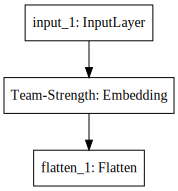

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
Team-Strength (Embedding)    (None, 1, 1)              10888     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
Total params: 10,888
Trainable params: 10,888
Non-trainable params: 0
_________________________________________________________________


None

In [7]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model
def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
display(visualize_model(team_strength_model))

display(team_strength_model.summary())

# Create the Neural network

## create the input layers

In [8]:
# Load the input layer from keras.layers
from keras.layers import Input

# Input layer for team 1
team_in_1 = Input((1,), name="Team-1-In")

# Separate input layer for team 2
team_in_2 = Input((1,), name="Team-2-In")

## connects them to the shared embed layer

In [9]:
# Imports
from keras.layers import Input, Embedding, Flatten
from keras.models import Model

# Lookup team 1 in the team strength model
team_1_strength = team_strength_model(team_in_1)

# Lookup team 2 in the team strength model
team_2_strength = team_strength_model(team_in_2)

## merge the layers with a substract operation

In [10]:
# Import the Subtract layer from keras
from keras.layers import Subtract

# Create a subtract layer using the inputs from the previous exercise
score_diff = Subtract()([team_1_strength, team_2_strength])

## compile the model

In [11]:
# Create the model
model = Model([team_in_1, team_in_2], score_diff)

# Compile the model
model.compile(optimizer = "adam", loss = "mean_absolute_error")

## visualize structure

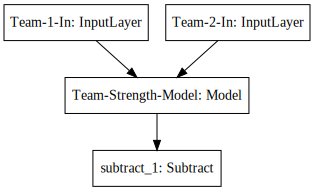

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Team-1-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-2-In (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
Team-Strength-Model (Model)     (None, 1)            10888       Team-1-In[0][0]                  
                                                                 Team-2-In[0][0]                  
__________________________________________________________________________________________________
subtract_1 (Subtract)           (None, 1)            0           Team-Strength-Model[1][0]        
          

None

In [12]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

#Visualize Model
def visualize_model(model):
  return SVG(model_to_dot(model).create(prog='dot', format='svg'))
#create your model
#then call the function on your model
display(visualize_model(model))

display(model.summary())

## predict 

In [13]:
# Get the team_1 column from the regular season data
input_1 = games_season["team_1"]

# Get the team_2 column from the regular season data
input_2 = games_season["team_2"]

y = games_season["score_diff"]

# Fit the model to input 1 and 2, using score diff as a target
model.fit(x=[input_1, input_2],
          y=y,
          epochs=1,
          batch_size=2048,
          validation_split=0.1,
          verbose=True)

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 0s 1us/step - loss: 12.1203 - val_loss: 11.8381


## validate

In [14]:

# Get team_1 from the tournament data
input_1 = games_tourney["team_1"]

# Get team_2 from the tournament data
input_2 = games_tourney["team_2"]

# Evaluate the model using these inputs
print(model.evaluate([input_1, input_2], games_tourney["score_diff"], verbose=False))

11.68016315463809
